In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# amit:
dataset = '/Predict Future Sales'
root_path = '/content/gdrive/My Drive/University/Deep Learning'
dataset_path = root_path + dataset

item_categories_csv = '/item_categories.csv'
items_csv = '/items.csv'
sales_train_csv = '/sales_train.csv'
sample_submission_csv = '/sample_submission.csv'
shops_csv = '/shops.csv'
test_csv = '/test.csv'

###Import essential liberies 

In [ ]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import math
import datetime

from keras.layers import Input, Embedding, dot, add,Flatten, concatenate,Dropout, Dense, BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from IPython.display import HTML
from matplotlib import pyplot as plt
from statistics import mean 
from math import sqrt

In [ ]:
def plot_history(history_plt):
  plt.plot(history_plt.history['loss'])
  plt.plot(history_plt.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

###Load the data from the csv files

In [ ]:
#load train data:
train_data = pd.read_csv(dataset_path + sales_train_csv)

#load test data:
test_data =  pd.read_csv(dataset_path + test_csv)

#load items data
items_data = pd.read_csv(dataset_path + items_csv)

#load train data:
item_categories_data = pd.read_csv(dataset_path + item_categories_csv)

#load test data:
sample_submission_data = pd.read_csv(dataset_path + sample_submission_csv)

#load items data
shops_data = pd.read_csv(dataset_path + shops_csv)

The shape and head of the training data

In [ ]:
print(train_data.shape)
train_data.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


The shape and head of the test data

In [ ]:
print(test_data.shape)
test_data.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


###**3.b-c Preprocessing and Use a classical ML algorithm**:
1. We will discard all rows that has value (-1) in '*item_cnt_day*' column.
2. In the train dataset we have some items and shops that not contained in the test dataset. thus, we will clear all rows in the train dataset that contains those shops and items. By doing that, we're preventing from our model to be overfitted to his data.
3. Change the date representation in the training dataset to seprated columns of '*month*' and '*year*'. those columns will serve us later as embedded features.
4. Add '*month*' = 11 and '*year*' = 2015 columns. This will be the month we want to predict.
5. We will group by '*month*' and '*year*' the items training sales data.
6. From exploring the data so far, we can see that approximatly we 5500 record of items that was selled by store in amount of more than 20 units. however, we have 665816 records in total. According to this distinction, we would like to make a clip for the values of the quantity of units sold of any product in a particular month to a range of 0-20
7. Dividing the training set to 80% training and 20% validation

In [ ]:
#1. We will discard all rows that has value (-1) in 'item_cnt_day' column.
train_data_fix = train_data.drop(train_data[train_data.item_cnt_day == -1.0].index)

#2. In the train dataset we have some items and shops that not contained in the 
#   test dataset. thus, we will clear all rows in the train dataset that contains 
#   those shops and items. By doing that, we're preventing from our model to be 
#   overfitted to his data.
shops = test_data['shop_id'].unique()
items = test_data['item_id'].unique()

train_data_fix = train_data_fix[train_data['shop_id'].isin(shops)]
train_data_fix = train_data_fix[train_data['item_id'].isin(items)]
train_data_fix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


The new shape of the train dataset will be:

In [ ]:
train_data_fix.shape

(1221546, 6)

In [ ]:
train_data_fix.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0


In [ ]:
#3. Change the date representation in the training dataset to seprated columns of 'month' and 'year'. those columns will serve us later as embedded features.
train_data_fix['date'] = pd.to_datetime(train_data_fix['date'], format='%d.%m.%Y')
train_data_fix['month'] = train_data_fix['date'].dt.month
train_data_fix['year'] = train_data_fix['date'].dt.year
train_data_fix = train_data_fix.drop(['date'], axis=1)
train_data_fix.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,0,59,22154,999.0,1.0,1,2013
10,0,25,2574,399.0,2.0,1,2013
11,0,25,2574,399.0,1.0,1,2013
12,0,25,2574,399.0,1.0,1,2013
13,0,25,2574,399.0,2.0,1,2013


In [ ]:
#4. Add 'month' = 11 and 'year' = 2015 columns. 
#   This month will be the month we want to predict it's results.
test_data_fix = test_data
test_data_fix['month'] = 11
test_data_fix['year'] = 2015
test_data_fix = test_data_fix[['shop_id', 'item_id', 'month', 'year']]
test_data_fix.head()

,shop_id,item_id,month,year
0,5,5037,11,2015
1,5,5320,11,2015
2,5,5233,11,2015
3,5,5232,11,2015
4,5,5268,11,2015


In [ ]:
#5. We will group by 'shop_id', 'item_id', 'item_price','month', 'year' the items training sales data.
#   We will also change the name of item_cnt_day to the new more-suitable name: 'item_cnt_month'
train_data_fix = train_data_fix.groupby(['shop_id', 'item_id', 'item_price','month', 'year'])['item_cnt_day'].sum().reset_index()
train_data_fix.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
train_data_fix

,shop_id,item_id,item_price,month,year,item_cnt_month
0,2,30,169.0,4,2014,1.0
1,2,30,169.0,5,2014,1.0
2,2,30,359.0,3,2013,1.0
3,2,30,399.0,6,2013,1.0
4,2,31,399.0,10,2015,1.0
...,...,...,...,...,...,...
665811,59,22164,749.0,2,2015,2.0
665812,59,22164,749.0,3,2015,1.0
665813,59,22167,299.0,6,2014,1.0
665814,59,22167,299.0,10,2013,1.0


**Visualization**:

We will now introduce a number of visual aids to help us get some sense of the unit numbers sold in stores as well as the unit numbers sold by month.

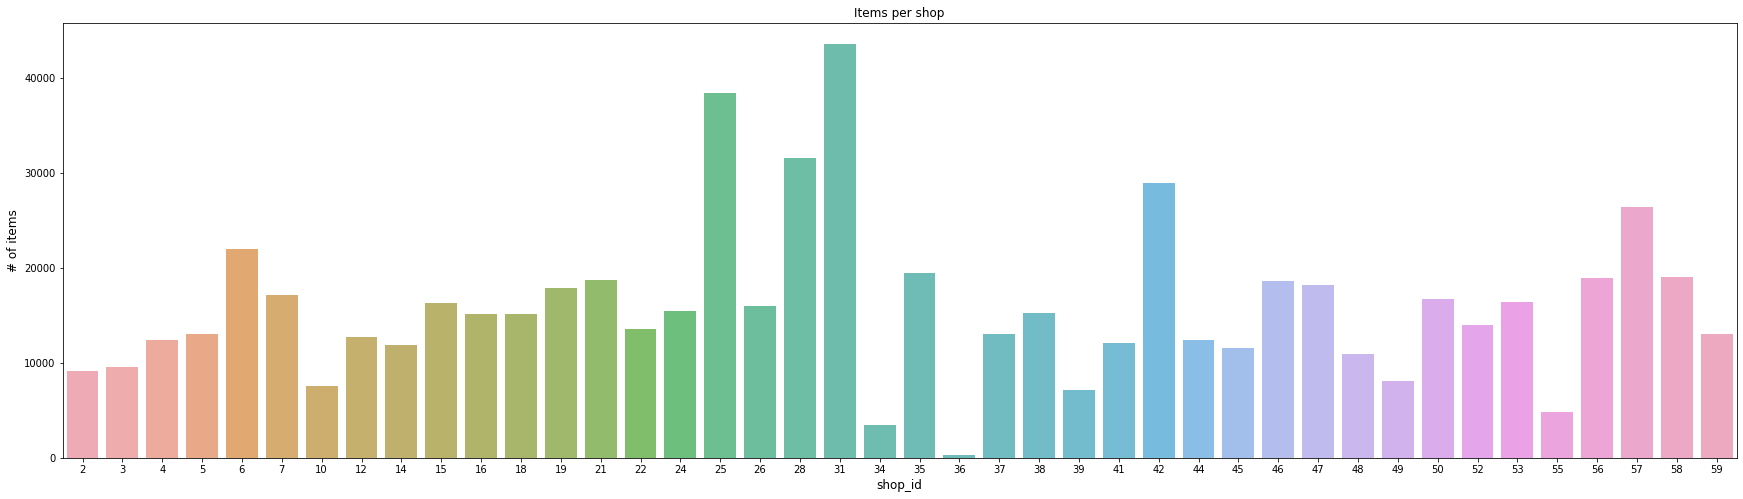

In [ ]:
# number of items in sales 
x = train_data_fix
x=train_data_fix.groupby(['shop_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:].reset_index()
x
#plot
plt.figure(figsize=(30,8))
ax= sns.barplot(x.shop_id, x.item_id, alpha=0.8)
plt.title("Items per shop")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('shop_id', fontsize=12)
plt.show()

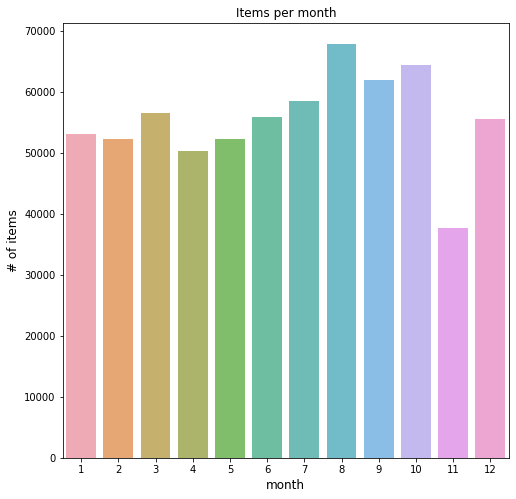

In [ ]:
# number of items in sales 
x = train_data_fix
x=train_data_fix.groupby(['month']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:].reset_index()
x
#plot
plt.figure(figsize=(8,8))
ax= sns.barplot(x.month, x.item_id, alpha=0.8)
plt.title("Items per month")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('month', fontsize=12)
plt.show()

**Discard noise**:

After examining the data set, we found that in a rough estimate, only 5500 products were sold in more than 20 units in one month at a particular store.
Therefore, we will refer to this data as noise that we would like not to place much importance on.
We will perform a clip process on the values so that they will be in a range of 0-20

In [ ]:
train_data_fix.nlargest(5500, 'item_cnt_month')

,shop_id,item_id,item_price,month,year,item_cnt_month
98323,12,11373,0.908714,10,2015,2169.0
355571,31,20949,5.000000,12,2013,1280.0
355572,31,20949,5.000000,12,2014,1209.0
264615,25,20949,5.000000,12,2013,1066.0
103057,12,20949,4.000000,1,2015,1000.0
...,...,...,...,...,...,...
612175,57,3731,1999.000000,7,2015,20.0
612186,57,3732,2592.500000,9,2013,20.0
612836,57,4178,1590.000000,4,2014,20.0
612837,57,4178,1590.000000,4,2015,20.0


In [ ]:
#6. From exploring the data so far, we can see that approximatly we 5500 record 
#   of items that was selled by store in amount of more than 20 units. however, 
#   we have 665816 records in total. According to this distinction, we would like 
#   to make a clip for the values of the quantity of units sold of any product in
#   a particular month to a range of 0-20.

train_data_fix['item_cnt_month'] = train_data_fix['item_cnt_month'].clip(0, 20)
train_data_fix

,shop_id,item_id,item_price,month,year,item_cnt_month
0,2,30,169.0,4,2014,1.0
1,2,30,169.0,5,2014,1.0
2,2,30,359.0,3,2013,1.0
3,2,30,399.0,6,2013,1.0
4,2,31,399.0,10,2015,1.0
...,...,...,...,...,...,...
665811,59,22164,749.0,2,2015,2.0
665812,59,22164,749.0,3,2015,1.0
665813,59,22167,299.0,6,2014,1.0
665814,59,22167,299.0,10,2013,1.0


In [ ]:
train_data_fix.nlargest(500000, 'item_cnt_month')

,shop_id,item_id,item_price,month,year,item_cnt_month
291,2,1495,599.0,12,2013,20.0
385,2,1555,1299.0,11,2014,20.0
401,2,1556,2999.0,11,2014,20.0
574,2,1857,2599.0,12,2013,20.0
861,2,2293,999.0,11,2014,20.0
...,...,...,...,...,...,...
408145,38,20736,399.0,9,2014,1.0
408146,38,20736,399.0,11,2014,1.0
408147,38,20736,399.0,12,2014,1.0
408149,38,20736,499.0,4,2015,1.0


**Fitting a classic ML Algorithm**:

We chose to use Random Forest Regressor algorithm.

In [ ]:
random_forest_regressor = RandomForestRegressor(n_estimators=75, max_depth=7, random_state=0, n_jobs=-1)
to_train = train_data_fix.sample(frac=0.8,random_state=200) #random state is a seed value

X_train = to_train[['shop_id', 'item_id', 'month', 'year']]
Y_train = to_train[['item_cnt_month']]

to_validation = train_data_fix.drop(to_train.index)
X_val = to_validation[['shop_id', 'item_id', 'month', 'year']]
Y_val = to_validation[['item_cnt_month']]


ml_history = random_forest_regressor.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


In [ ]:
ml_prediction_val = random_forest_regressor.predict(X_val)
ml_rmse_val = sqrt(mean_squared_error(Y_val, ml_prediction_val))

ml_prediction_val = random_forest_regressor.predict(X_val)
ml_rmse_val = sqrt(mean_squared_error(Y_val, ml_prediction_val))

ml_prediction_test = random_forest_regressor.predict(test_data_fix)

print(ml_rmse_val)

2.443456633402323


In [ ]:
ml_prediction_test_to_file = pd.DataFrame(ml_prediction_test, columns=['item_cnt_month'])
ml_prediction_test_to_file.to_csv(dataset_path + '/ml_submission.csv',index_label='ID')

In [ ]:
print("Submission 1 score: 1.90068")

Submission 1 score: 1.90068


As we can see we got a reasonable result for the validation part of the data.
We now will make a prediction on the test data also and submit it to kaggle.

###3.c create an embedding for the dataset relevant variables.

In [ ]:
n_factors = 35
unq_shop_length = train_data_fix['shop_id'].max() + 1
unq_item_length = train_data_fix['item_id'].max() + 1
unq_month_length = train_data_fix['month'].max() + 1
unq_shop_length, unq_item_length, unq_month_length, n_factors 

(60, 22168, 13, 35)

In [ ]:
#1. We will use embedding layer to improve our result as shown in class
shop_in = Input(shape=(1,), dtype='int64')
s_embd = Embedding(unq_shop_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(shop_in)

item_in = Input(shape=(1,), dtype='int64')
i_embd = Embedding(unq_item_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(item_in)

month_in = Input(shape=(1,), dtype='int64')
m_embd = Embedding(unq_month_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(month_in)


###3.d

In [ ]:
#2. Creating a model
x = concatenate([s_embd,i_embd, m_embd])
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(10,activation='relu')(x)
x = Dense(10,activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1,activation='relu')(x)
nn_model = Model([shop_in,item_in,month_in],x)
nn_model.compile(loss = 'mse',optimizer='adam')
nn_model.summary()

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_65 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 1, 50)        3000        input_63[0][0]                   
___________________________________________________________________________________________

In [ ]:
history=nn_model.fit([X_train['shop_id'], X_train['item_id'], X_train['month']] ,Y_train['item_cnt_month'],epochs=30,
                 validation_data=([X_val['shop_id'], X_val['item_id'], X_val['month']], Y_val['item_cnt_month']) ,batch_size = 4096)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 532653 samples, validate on 133163 samples
Epoch 1/30
532653/532653 [==============================] - 6s 11us/step - loss: 8.7934 - val_loss: 9.0292
Epoch 2/30
532653/532653 [==============================] - 5s 9us/step - loss: 7.2707 - val_loss: 8.3347
Epoch 3/30
532653/532653 [==============================] - 5s 9us/step - loss: 6.8705 - val_loss: 7.5725
Epoch 4/30
532653/532653 [==============================] - 5s 9us/step - loss: 6.6051 - val_loss: 6.6986
Epoch 5/30
532653/532653 [==============================] - 5s 10us/step - loss: 6.3798 - val_loss: 6.2409
Epoch 6/30
532653/532653 [==============================] - 7s 14us/step - loss: 6.2416 - val_loss: 5.8120
Epoch 7/30
532653/532653 [==============================] - 6s 11us/step - loss: 6.0621 - val_loss: 5.7130
Epoch 8/30
532653/532653 [==============================] - 5s 9us/step - loss: 5.8906 - val_loss: 5.6665
Epoch 9/30
532653/532653 [==============================] - 5s 10us/step - loss: 5.7809 - val_lo

In [ ]:
dl_prediction_train = nn_model.predict([X_train['shop_id'], X_train['item_id'], X_train['month']])
dl_rmse_train = sqrt(mean_squared_error(Y_train, dl_prediction_train))
print("train prediction:", dl_rmse_train)

dl_prediction_val = nn_model.predict([X_val['shop_id'], X_val['item_id'], X_val['month']])
dl_rmse_val = sqrt(mean_squared_error(Y_val, dl_prediction_val))
print("validation prediction:",dl_rmse_val)


dl_prediction_test = nn_model.predict([test_data_fix['shop_id'], test_data_fix['item_id'], test_data_fix['month']])

train prediction: 2.1691525253310333
validation prediction: 2.2236633493669524


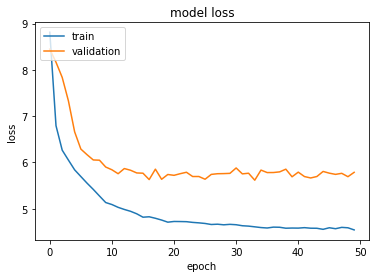

In [ ]:
plot_history(history)

In [ ]:
dl_prediction_test_to_file = pd.DataFrame(dl_prediction_test, columns=['item_cnt_month'])
dl_prediction_test_to_file.to_csv(dataset_path + '/submission.csv',index_label='ID')

In [ ]:
print("Submission 2 score: 1.86864")

Submission 2 score: 1.86864


###3.e

In the last model we used only 3 features, now we would like to increase the number of features to get a better result.

In [ ]:
unq_year_length = train_data_fix['year'].max() + 1

#1. We will use embedding layer to improve our result as shown in class
shop_in = Input(shape=(1,), dtype='int64')
s_embd = Embedding(unq_shop_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(shop_in)

item_in = Input(shape=(1,), dtype='int64')
i_embd = Embedding(unq_item_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(item_in)

month_in = Input(shape=(1,), dtype='int64')
m_embd = Embedding(unq_month_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(month_in)

year_in = Input(shape=(1,), dtype='int64')
y_embd = Embedding(unq_year_length, 50, input_length=1, embeddings_regularizer=l2(1e-4))(year_in)

In [ ]:
y = concatenate([s_embd,i_embd, m_embd, y_embd])
y = Flatten()(y)
y = BatchNormalization()(y)
y = Dense(10,activation='relu')(y)
y = Dense(10,activation='relu')(y)
y = Dropout(0.4)(y)
y = BatchNormalization()(y)
y = Dense(10,activation='relu')(y)
y = Dense(10,activation='relu')(y)
y = Dropout(0.7)(y)
y = Dense(1,activation='relu')(y)
nn_model_extra_feature = Model([shop_in,item_in,month_in, year_in],y)
nn_model_extra_feature.compile(loss = 'mse',optimizer='adam')

In [ ]:
nn_model_extra_feature.compile(loss = 'mse',optimizer='adam')
nn_model_extra_feature.summary()

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_65 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_66 (InputLayer)           (None, 1)            0                                            
___________________________________________________________________________________________

In [ ]:
history_extra_feature=nn_model_extra_feature.fit([X_train['shop_id'], X_train['item_id'], X_train['month'], X_train['year']] ,Y_train['item_cnt_month'],epochs=30,
                 validation_data=([X_val['shop_id'], X_val['item_id'], X_val['month'], X_val['year']], Y_val['item_cnt_month']) ,batch_size = 4096)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 532653 samples, validate on 133163 samples
Epoch 1/30
532653/532653 [==============================] - 6s 12us/step - loss: 8.9359 - val_loss: 8.4655
Epoch 2/30
532653/532653 [==============================] - 6s 11us/step - loss: 6.8658 - val_loss: 7.6270
Epoch 3/30
532653/532653 [==============================] - 6s 11us/step - loss: 6.3580 - val_loss: 6.9463
Epoch 4/30
532653/532653 [==============================] - 6s 11us/step - loss: 6.0638 - val_loss: 5.9917
Epoch 5/30
532653/532653 [==============================] - 6s 11us/step - loss: 5.8725 - val_loss: 5.2956
Epoch 6/30
532653/532653 [==============================] - 6s 10us/step - loss: 5.6585 - val_loss: 5.0916
Epoch 7/30
532653/532653 [==============================] - 6s 11us/step - loss: 5.5029 - val_loss: 5.0341
Epoch 8/30
532653/532653 [==============================] - 6s 11us/step - loss: 5.3666 - val_loss: 4.8054
Epoch 9/30
532653/532653 [==============================] - 6s 11us/step - loss: 5.2114 - va

In [ ]:
dl_prediction_train_extra_feature = nn_model_extra_feature.predict([X_train['shop_id'], X_train['item_id'], X_train['month'], X_train['year']])
dl_rmse_train_extra_feature = sqrt(mean_squared_error(Y_train, dl_prediction_train_extra_feature))
print("train prediction extra feature:", dl_rmse_train_extra_feature)

dl_prediction_val_extra_feature = nn_model_extra_feature.predict([X_val['shop_id'], X_val['item_id'], X_val['month'], X_val['year']])
dl_rmse_val_extra_feature = sqrt(mean_squared_error(Y_val, dl_prediction_val_extra_feature))
print("validation prediction extra feature:", dl_rmse_val)


dl_prediction_test_extra_feature = nn_model_extra_feature.predict([test_data_fix['shop_id'], test_data_fix['item_id'], test_data_fix['month'], test_data_fix['year']])
# dl_rmse_val = sqrt(mean_squared_error(Y_val, dl_prediction_test))
# print(dl_rmse_val)
# test_data_fix.shape

train prediction extra feature: 2.1432303668424124
validation prediction extra feature: 2.2236633493669524


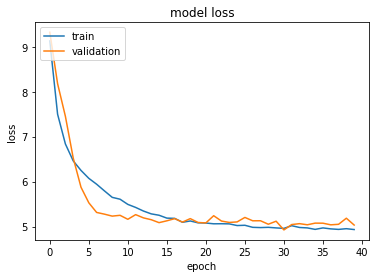

In [ ]:
plot_history(history_extra_feature)

In [ ]:
dl_prediction_test_to_file_extra = pd.DataFrame(dl_prediction_test_extra_feature, columns=['item_cnt_month'])
dl_prediction_test_to_file_extra.to_csv(dataset_path + '/submission4f.csv',index_label='ID')

In [ ]:
print("Submission 3 score: 1.80460")

Submission 3 score: 1.80460


In [ ]:
# Training comparison:
print("train 3 features score:", dl_rmse_train)
print("train 4 features score:", dl_rmse_train_extra_feature)

# Validation comparison:
print("\nvalidation 3 features score:", dl_rmse_val)
print("validation 4 features score:", dl_rmse_val_extra_feature)

train 3 features score: 2.1691525253310333
train 4 features score: 2.1432303668424124

validation 3 features score: 2.2236633493669524
validation 4 features score: 2.200417320654311


###3.f

**After the first fit we saw**:
1. Predictable results for training set and validation.
2. The training is done by embedding 3 features.
3. The ratio between training results and validation results was good, meaning we are not in overfitting.

**After the second fit we saw**:
1. Prediction results improved in both training set and validation set.
2. The training is done by embedding 4 features.
3. The ratio between training results and validation results was good, meaning we are not in overfitting.
4. We assume that as we add more features the prediction results will improve

###3.g

Next, we will perform a feature extraction process from the model we trained in the previous step and insert it as an input to the Classic Machine Learning model.

In [ ]:
# Extracting the last layer of the first model we trained:
nn_model.layers.pop()
# Extracting the last layer of the second model we trained:
nn_model_extra_feature.layers.pop()

In [ ]:
# We will use Linear Regression as our Machine learning algorithm.
linear_regression_fe = LinearRegression()
linear_regression_fe_extra = LinearRegression()

In [ ]:
# First we will fit our model on the first nural network we built with 3 features
linear_regression_fe.fit(nn_model.predict([X_train['shop_id'], X_train['item_id'], X_train['month']]), Y_train['item_cnt_month'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Now, we will see if the validation score improved
pred_ml_fe = linear_regression_fe.predict(nn_model.predict([X_val['shop_id'], X_val['item_id'], X_val['month']]))
ml_lr = sqrt(mean_squared_error(Y_val['item_cnt_month'], pred_ml_fe))
print("pred_ml_fe", ml_lr)

pred_ml_fe 2.0254009687438566


In [ ]:
# Test set score for 3 features
ml_prediction_fe_test = linear_regression_fe.predict(nn_model.predict([test_data_fix['shop_id'], test_data_fix['item_id'], test_data_fix['month']]))
dl_prediction_test_to_file_fe = pd.DataFrame(ml_prediction_fe_test, columns=['item_cnt_month'])
dl_prediction_test_to_file_fe.to_csv(dataset_path + '/submissionfe.csv',index_label='ID')

In [ ]:
print("Submission 4 score: 2.21457")

Submission 4 score: 2.21457


In [ ]:
# Next, we will fit our model on the second nural network we built with 4 features
linear_regression_fe_extra.fit(nn_model_extra_feature.predict([X_train['shop_id'], X_train['item_id'], X_train['month'], X_train['year']]), Y_train['item_cnt_month'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Now, we will see if the validation score improved
pred_ml_fe = linear_regression_fe_extra.predict(nn_model_extra_feature.predict([X_val['shop_id'], X_val['item_id'], X_val['month'], X_val['year']]))
ml_lr_extra = sqrt(mean_squared_error(Y_val['item_cnt_month'], pred_ml_fe))
print("pred_ml_fe_extra", ml_lr_extra)

pred_ml_fe_extra 1.9917260018330594


In [ ]:
# Test set score for 4 features
ml_prediction_fe_extra_test = linear_regression_fe_extra.predict(nn_model_extra_feature.predict([test_data_fix['shop_id'], test_data_fix['item_id'], test_data_fix['month'], test_data_fix['year']]))

In [ ]:
ml_prediction_fe_extra_test = linear_regression_fe.predict(nn_model.predict([test_data_fix['shop_id'], test_data_fix['item_id'], test_data_fix['month']]))
dl_prediction_test_to_file_fe_extra = pd.DataFrame(ml_prediction_fe_extra_test, columns=['item_cnt_month'])
dl_prediction_test_to_file_fe_extra.to_csv(dataset_path + '/submissionfextra.csv',index_label='ID')

In [ ]:
print("Submission 5 score: 2.21457")

Submission 5 score: 2.21457


###4 - Report
The task we investigated is predicting the number of units that will be sold in stores in the next month.
Like every ML/DL task, the first thing we would like to do is to preprocess our data if he is not already ready to use.
These steps were critical to our model in terms of both the model's complexity and its correctness.
The processes we performed are:

1. discard all rows that has value (-1) in '*item_cnt_day*' column.
2. clear all rows in the training dataset that contains shops and items that not in test-set 
3. Fixing the date representation, so later on we could use him as features.
4. Fixing the test-set by adding the month we want to predict.
5. Grouping the records so that the units counter is by months and not by days. 
6. Discard values that are far less common and if so can significantly impact the results of the model.
7. Dividing the training set to 80% training and 20% validation.

The next thing we were asked to do is do the training and prediction on the data set and test using a classic ML algorithm. The results obtained were not bad, but there seemed to be room for improvement.

At this point, we started to build an RNN model when we want to extract features from the data. We did this with Embedding.
First we only used 3 features and we built a neuron network for the data in the training set. Already at this stage, when we only run the model with 3 features we got a better result than the previous step (ML).

Now we have decided to add another feature that we think will affect the result and this is the year feature. Once again it was noticeable that there was a positive change in the prediction results.

The final step in the task was to perform a feature-extractor process from the models we trained in the previous step.
To complete the task:
- We pulled the last layer from both models.
- We created a new ML model. (We chose to use logistic regression).
- We performed prediction with the original models (without the last layer) for the test-set.
- The output from the previous step was entered as an input to the ML model.

Result:
Surprisingly, the results we received were less accurate than the results we described in the previous steps.

The reasons that caused the surprising results in our opinion are:
1. Wrong choice of ML algorithm for the task that you are trying to perform.
2. The Feature Extractor process was performed incorrectly.

To summarize, The key points in our opinion are:

1. A thorough preprocess that not ignores important details and yet knows how to deal with less common or unimportant details.
2. Choosing features that will improve prediction based on the research done on data in the early stages. For example, we could see from the tables we attached above that in some months sales dropped and others went up. Therefore, choosing a month as a feature made the model prediction more accurate.
